https://www.datacamp.com/tutorial/random-forests-classifier-python
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [1]:
import pandas as pd
from itertools import product
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:
original = pd.read_csv('train.csv')


In [3]:
# drop rows where tempo is missing
original = original[original['Tempo'].notna()]
# drop rows where genre speechness and valence are missing
#original = original[original['Speechiness'].notna()]
# original = original[original['Valence'].notna()]

In [4]:
training_Y = original['Danceability']
original.drop(['Danceability'], axis=1, inplace=True) 

In [5]:
def fillOptions(data, option = 'max'):
    if data.isna().sum() != len(data):
        if option == 'max':
            return data.value_counts().idxmax()
        elif option == 'mean':
            return data.mean()
        elif option == 'median':
            return data.median()

In [6]:
def verifyID(original, newData):
    noInNewData = original[~original['id'].isin(newData['id'])]
    return pd.concat([newData, noInNewData], ignore_index=True)   

In [7]:
def filterArtistComposerDance(data, nameColumnFill):

    listArtist = data['Artist'].unique()
    listComposer = data['Composer'].unique()
    
    filter = list(product(listArtist, listComposer))

    newData = pd.DataFrame(columns=data.columns)

    for i in filter:
        artist, composer = i[0], i[1]
        filterData = data[(data['Artist'] == artist) & (data['Composer'] == composer) ]
        if len(filterData) != 0:
            # Fill column Name
            for nameColumn in nameColumnFill:
                fillInfo = fillOptions(filterData[nameColumn], option = 'max')
                if fillInfo != None:
                    filterData.loc[:,nameColumn].fillna(fillInfo, inplace=True)

            newData = pd.concat([newData, filterData], ignore_index=True)
    return newData

In [8]:
def filterArtist(data, nameColumnFill):
    listDance = data['Artist'].unique()
    filter = listDance


    newData = pd.DataFrame(columns=data.columns)

    for i in filter:
        dance = i
        filterData = data[ (data['Artist'] == dance)]
    
    
        if len(filterData) != 0:
            # Fill column Name
            for nameColumn in nameColumnFill:
                fillInfo = fillOptions(filterData[nameColumn], option = 'max')
                if fillInfo != None:
                    filterData.loc[:,nameColumn].fillna(fillInfo, inplace=True)

            newData = pd.concat([newData, filterData], ignore_index=True)

    return newData

In [9]:
def filterFillData(data, nameColumnFill):
    if not data.isnull().any().any():
        return data
    else:
        for nameColumn in nameColumnFill:
            fillInfo = fillOptions(data[nameColumn], option = 'max')
            if fillInfo != None:
                data.loc[:,nameColumn].fillna(fillInfo, inplace=True)
    return data



In [10]:
def dataPreprocessing(original):
    
    pd.options.mode.chained_assignment = None

    data = original.copy()

    nameColumnFill = ['Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Duration_ms', 'Views', 'Likes', "Stream" , "Comments"]

    # License and official_video
    data['Licensed'].fillna(data['official_video'], inplace=True)
    data['Licensed'].fillna(False, inplace=True)

    data['official_video'].fillna(data['Licensed'], inplace=True)
    data['official_video'].fillna(False, inplace=True)

    data['official_video'].fillna(False, inplace=True)
    data['Licensed'].fillna(False, inplace=True)

    data['Licensed'].replace({True: 1, False: 0})
    data['official_video'].replace({True: 1, False: 0})

    # Create new class = 'Unknown'
    data['Composer'].fillna("Unknown", inplace=True)
    data['Artist'].fillna("Unknown", inplace=True)
    data['Album_type'].fillna("Unknown", inplace=True)

    

    newData = filterArtistComposerDance(data, nameColumnFill)
    data = newData.copy()

    newData = filterArtist(data, nameColumnFill)
    data = newData.copy()

    newData = filterFillData(data, nameColumnFill)
    data = newData.copy()

    #Transform type key to use as class
    data['Key'] = data['Key'].astype(int)
    data['Key'] = data['Key'].astype(str)

    data = data.sort_values('id')

    # DELETE Track, Album, Uri, Url_spotify, Url_youtube, Description, Title, Channel, id, Comments
    data.drop(['Track', 'Album', 'Uri', 'Url_spotify', 'Url_youtube', 'Description', 'Title', 'Channel', 'id'], axis=1, inplace=True)

    pd.options.mode.chained_assignment = 'warn'

    return data
    


In [11]:
def convertEncoderPD(data, prefix = 'key'):
    titleKeys = []
    for i in range(data.shape[1]):
        titleKeys.append(f'{prefix}_{i}')
    
    return pd.DataFrame(data=data, columns= titleKeys)


In [12]:
def createEncodeDataTraining(data):

    encoderKey = OneHotEncoder()
    encodedKey = encoderKey.fit_transform(data[['Key']])
    Key = encodedKey.toarray()
    key_pd = convertEncoderPD(Key, prefix = 'key')

    encoderAlbumType = OneHotEncoder()
    encodedKeyAlbumType = encoderAlbumType.fit_transform(data[['Album_type']])
    AlbumType = encodedKeyAlbumType.toarray()
    AlbumType_pd = convertEncoderPD(AlbumType, prefix = 'AlbumType')

    encoderComposer = OneHotEncoder()
    encodedKeyComposer = encoderComposer.fit_transform(data[['Composer']])
    Composer = encodedKeyComposer.toarray()
    Composer_pd = convertEncoderPD(Composer, prefix = 'Composer')   

    encoderArtist = LabelEncoder()
    encodedArtist = encoderArtist.fit_transform(data[['Artist']])
    encodedArtist = encodedArtist.ravel()
    Artist_pd =  pd.DataFrame(data=encodedArtist, columns= ["Artist"])

    data.drop(['Key','Album_type', 'Composer',  'Artist'], axis=1, inplace=True)

    data = pd.concat([data, key_pd, AlbumType_pd, Composer_pd, Artist_pd], axis=1)

    scaler = StandardScaler()
    scaledData = scaler.fit_transform(data)

    scaledData_pd = pd.DataFrame(data=scaledData, columns= data.columns)

    return {"key": encoderKey, 'AlbumType': encoderAlbumType, 'Composer': encoderComposer, "Artist":encoderArtist} , scaler, data, scaledData_pd
    

In [13]:
def createEncodeDataTesting(encoder, scalerStandard, data):

    encoderKey = encoder['key']
    encodedKey = encoderKey.transform(data[['Key']])
    Key = encodedKey.toarray()
    key_pd = convertEncoderPD(Key, prefix = 'key')

    encoderAlbumType = encoder['AlbumType']
    encodedKeyAlbumType = encoderAlbumType.transform(data[['Album_type']])
    AlbumType = encodedKeyAlbumType.toarray()
    AlbumType_pd = convertEncoderPD(AlbumType, prefix = 'AlbumType')

    encoderComposer = encoder['Composer']
    encodedKeyComposer = encoderComposer.transform(data[['Composer']])
    Composer = encodedKeyComposer.toarray()
    Composer_pd = convertEncoderPD(Composer, prefix = 'Composer')   

    encoderArtist = encoder['Artist']
    encodedArtist = encoderArtist.transform(data[['Artist']])
    encodedArtist = encodedArtist.ravel()
    Artist_pd =  pd.DataFrame(data=encodedArtist, columns= ["Artist"])

    data.drop(['Key','Album_type', 'Composer',  'Artist'], axis=1, inplace=True)

    data = pd.concat([data, key_pd, AlbumType_pd, Composer_pd, Artist_pd], axis=1)

    scaler = scalerStandard
    scaledData = scaler.transform(data)

    scaledData_pd = pd.DataFrame(data=scaledData, columns= data.columns)

    return data, scaledData_pd

In [14]:
data = dataPreprocessing(original)

/tmp/ipykernel_29624/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_29624/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_29624/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_29624/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Exp

In [15]:
encoders, scalerStandard, data, scaledData_pd = createEncodeDataTraining(data)

/home/zow/anaconda3/envs/fintech2/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
test = pd.read_csv('test.csv')
dataTest = dataPreprocessing(test)
testOriginal, testScaled = createEncodeDataTesting(encoders, scalerStandard, dataTest)

/tmp/ipykernel_29624/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_29624/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_29624/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_29624/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Exp

In [17]:
scaledData_pd

,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Stream,Licensed,official_video,Comments,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,AlbumType_0,AlbumType_1,AlbumType_2,AlbumType_3,Composer_0,Composer_1,Composer_2,Composer_3,Composer_4,Composer_5,Composer_6,Composer_7,Composer_8,Composer_9,Composer_10,Artist
0,-1.393682,-3.772844,-0.477670,2.617848,-0.262135,-0.282206,-0.782981,-1.265492,-0.928189,-0.216233,-0.279446,-0.450898,-1.530368,-1.782832,-0.103597,-0.359152,-0.338281,-0.472164,-0.317013,5.826437,-0.263735,-0.285646,-0.263884,-0.359030,-0.275136,-0.315835,-0.416786,0.805571,-0.172685,-0.525811,-0.462487,-0.066854,-0.347012,-0.376425,-0.276859,-0.270501,-0.238786,-0.087105,-0.415541,2.387016,-0.315179,0.093096
1,-0.631003,-1.297983,-0.580081,2.392443,4.895343,0.022514,0.871506,0.935612,-0.443683,-0.346047,-0.361218,-0.486658,-1.530368,-1.782832,-0.117792,2.784339,-0.338281,-0.472164,-0.317013,-0.171631,-0.263735,-0.285646,-0.263884,-0.359030,-0.275136,-0.315835,-0.416786,0.805571,-0.172685,-0.525811,-0.462487,-0.066854,-0.347012,2.656570,-0.276859,-0.270501,-0.238786,-0.087105,-0.415541,-0.418933,-0.315179,0.812728
2,0.198322,-1.695826,-0.478665,2.372504,4.651621,-0.273601,-0.619978,-1.214892,-0.642303,-0.346047,-0.361218,-0.453773,-1.530368,-1.782832,-0.117792,-0.359152,-0.338281,-0.472164,-0.317013,-0.171631,-0.263735,3.500843,-0.263884,-0.359030,-0.275136,-0.315835,-0.416786,0.805571,-0.172685,-0.525811,-0.462487,-0.066854,-0.347012,2.656570,-0.276859,-0.270501,-0.238786,-0.087105,-0.415541,-0.418933,-0.315179,0.027675
3,-0.525836,0.330243,-0.642720,-0.508920,-0.262486,-0.280484,-0.848183,0.987122,0.355446,0.510942,0.251211,1.201563,0.653437,0.560905,-0.001129,-0.359152,-0.338281,2.117910,-0.317013,-0.171631,-0.263735,-0.285646,-0.263884,-0.359030,-0.275136,-0.315835,-0.416786,0.805571,-0.172685,-0.525811,-0.462487,-0.066854,2.881746,-0.376425,-0.276859,-0.270501,-0.238786,-0.087105,-0.415541,-0.418933,-0.315179,-1.738695
4,0.076649,0.615346,-0.659623,-0.525385,-0.259839,-0.263319,-0.966360,-0.773350,0.345558,0.994915,0.437716,-0.471746,0.653437,0.560905,0.031615,-0.359152,-0.338281,-0.472164,3.154445,-0.171631,-0.263735,-0.285646,-0.263884,-0.359030,-0.275136,-0.315835,-0.416786,0.805571,-0.172685,-0.525811,-0.462487,-0.066854,-0.347012,2.656570,-0.276859,-0.270501,-0.238786,-0.087105,-0.415541,-0.418933,-0.315179,1.139833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14603,1.897359,0.310080,-0.592012,-0.135112,-0.262486,-0.284136,0.512898,-1.042867,-1.130997,-0.341090,-0.363735,0.009100,0.653437,0.560905,-0.118380,-0.359152,-0.338281,-0.472164,-0.317013,-0.171631,-0.263735,-0.285646,3.789548,-0.359030,-0.275136,-0.315835,2.399314,-1.241356,-0.172685,-0.525811,-0.462487,-0.066854,-0.347012,-0.376425,-0.276859,-0.270501,-0.238786,-0.087105,2.406504,-0.418933,-0.315179,-0.332142
14604,2.005173,1.298290,0.682648,-0.525303,-0.262486,-0.282390,0.508823,1.818056,-0.640645,-0.346133,-0.363176,-0.490431,0.653437,0.560905,-0.118380,-0.359152,2.956124,-0.472164,-0.317013,-0.171631,-0.263735,-0.285646,-0.263884,-0.359030,-0.275136,-0.315835,-0.416786,-1.241356,-0.172685,1.901826,-0.462487,-0.066854,-0.347012,-0.376425,3.611946,-0.270501,-0.238786,-0.087105,-0.415541,-0.418933,-0.315179,0.518333
14605,0.975926,0.671065,-0.274838,-0.438050,-0.262486,-0.256824,-0.461049,1.599577,-0.762949,-0.346680,-0.364219,-0.222767,0.653437,0.560905,-0.118380,-0.359152,-0.338281,2.117910,-0.317013,-0.171631,-0.263735,-0.285646,-0.263884,-0.359030,-0.275136,-0.315835,-0.416786,0.805571,-0.172685,-0.525811,2.162224,-0.066854,-0.347012,-0.376425,-0.276859,-0.270501,-0.238786,-0.087105,-0.415541,-0.418933,-0.315179,0.093096
14606,0.476022,-0.871089,3.247877,-0.329559,-0.262486,-0.278167,0.027962,1.161001,-1.011267,-0.346803,-0.325406,-0.507945,0

In [18]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
#train_features, test_features, train_labels, test_labels = train_test_split(scaledData_pd, training_Y, test_size = 0.20, random_state = 123)
train_features, val_features, train_labels, val_labels = train_test_split(scaledData_pd, training_Y, test_size = 0.20, random_state = 123)

### RandomForestRegressor

In [19]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
import pickle

#Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

# filename = "random_forest_regressor.joblib"
# pickle.dump(rf, open(filename, "wb"))

RandomForestRegressor(n_estimators=1000, random_state=42)

In [20]:
# Use the forest's predict method on the val data
predictions = rf.predict(val_features)
# Calculate the absolute errors
predictions = np.rint(predictions)
errors = abs(predictions - val_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 1.7


In [21]:
# Use the forest's predict method on the test data
predictionsTest = rf.predict(testScaled)
predictionsTest = np.rint(predictionsTest)


In [22]:
predictionTest_pd = pd.DataFrame(data = predictionsTest, columns= ['Danceability'])
predictionTest_pd.to_csv('RandomForestRegressor.csv')

In [23]:
preds = np.rint(predictionsTest)
preds = preds.astype(int)
preds = pd.DataFrame(preds, columns=['Danceability'])
preds['id'] = preds.index + 17170
preds = preds[['id', 'Danceability']]
preds.to_csv('submissionRF.csv', index=False)

In [24]:
# # load model
# loaded_model = pickle.load(open(filename, "rb"))
# # you can use loaded model to compute predictions
# predicted = loaded_model.predict(test_features)

# predicted = np.rint(predicted)
# errors = abs(predicted - test_labels)
# # Print out the mean absolute error (mae)
# print('Mean Absolute Error:', round(np.mean(errors), 2))

# XGBOOST

In [25]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
best_params = {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.4, 'n_estimators': 400, 'min_child_weight': 4, 'max_depth': 30, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.8, 'random_state': 0}
default_params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'random_state': 0,
    'n_jobs': -1
}

best_model = XGBRegressor(**default_params)
best_model.fit(train_features, train_labels)


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [26]:

preds = best_model.predict(val_features)
mae = mean_absolute_error(val_labels, preds)
print(f"MAE without CV: {mae}")

MAE without CV: 1.7462629861635661


In [27]:
best_model.feature_importances_

array([0.08594095, 0.04444504, 0.14297625, 0.10396016, 0.03172156,
       0.03280337, 0.24423318, 0.11736909, 0.03352452, 0.02042207,
       0.03320416, 0.01216538, 0.01021645, 0.        , 0.01933899,
       0.00342533, 0.        , 0.        , 0.        , 0.01102375,
       0.        , 0.00550921, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00881779, 0.01198588, 0.        ,
       0.        , 0.        , 0.0117229 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00694072,
       0.        , 0.00825316], dtype=float32)

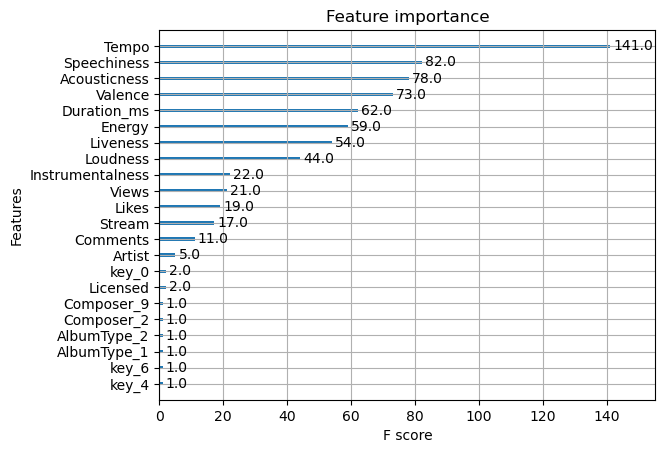

In [28]:
# plot feature importance
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(best_model)
pyplot.show()

In [29]:
# Use the forest's predict method on the test data
predictionsTest = best_model.predict(testScaled)
predictionsTest = np.rint(predictionsTest)
predictionTest_pd = pd.DataFrame(data = predictionsTest, columns= ['Danceability'])
predictionTest_pd.to_csv('XGB.csv')


In [30]:
preds = np.rint(predictionsTest)
preds = preds.astype(int)
preds = pd.DataFrame(preds, columns=['Danceability'])
preds['id'] = preds.index + 17170
preds = preds[['id', 'Danceability']]
preds.to_csv('submission.csv', index=False)

# ADABOOST

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
base_estimator = DecisionTreeRegressor(max_depth=3, splitter='best', min_samples_split=2)
model = AdaBoostRegressor(base_estimator=base_estimator,n_estimators=500, random_state=42) #n_estimators = 1000, random_state = 42
model.fit(train_features, train_labels)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                  n_estimators=500, random_state=42)

In [32]:

preds = model.predict(val_features)
mae = mean_absolute_error(val_labels, preds)
print(f"MAE without CV: {mae}")

MAE without CV: 2.052907470942129


# LIGHTGBM

In [33]:
import lightgbm as lgb
lgb_train = lgb.Dataset(train_features, train_labels)
lgb_eval = lgb.Dataset(val_features, val_labels, reference=lgb_train)
params = {'boosting_type': 'gbdt',
              'objective': 'regression',
              'num_leaves': 40,
              'learning_rate': 0.1,
              'feature_fraction': 0.9
              }
gbm = lgb.train(params,
    lgb_train,
    num_boost_round=200,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=['train','valid'],
   )


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3496
[LightGBM] [Info] Number of data points in the train set: 11686, number of used features: 42
[LightGBM] [Info] Start training from score 4.588054
[1]	train's l2: 7.68666	valid's l2: 7.71662
[2]	train's l2: 7.16593	valid's l2: 7.25274
[3]	train's l2: 6.73491	valid's l2: 6.85736
[4]	train's l2: 6.37208	valid's l2: 6.52526
[5]	train's l2: 6.11584	valid's l2: 6.30039
[6]	train's l2: 5.84342	valid's l2: 6.06456
[7]	train's l2: 5.61025	valid's l2: 5.86205
[8]	train's l2: 5.40195	valid's l2: 5.68031
[9]	train's l2: 5.2234	valid's l2: 5.5363
[10]	train's l2: 5.06316	valid's l2: 5.39821
[11]	train's l2: 4.92742	valid's l2: 5.28455
[12]	train's l2: 4.8131	valid's l2: 5.19685
[13]	train's l2: 4.70696	valid's l2: 5.11675
[14]	train's l2: 4

In [34]:

preds = gbm.predict(val_features)
mae = mean_absolute_error(val_labels, preds)
print(f"MAE without CV: {mae}")

MAE without CV: 1.6637101676438146


In [35]:
# Use the forest's predict method on the test data
predictionsTest = gbm.predict(testScaled)
preds = np.rint(predictionsTest)
preds = preds.astype(int)
preds = pd.DataFrame(preds, columns=['Danceability'])
preds['id'] = preds.index + 17170
preds = preds[['id', 'Danceability']]
preds.to_csv('submission.csv', index=False)

# Ensemble

In [36]:
class LGBWrapper:
    def __init__(self, params=None, num_boost_round=10):
        self.params = params
        self.num_boost_round = num_boost_round
        self.model = None

    def fit(self, X, y):
        lgb_train = lgb.Dataset(X, y, free_raw_data=False)
        self.model = lgb.train(self.params, lgb_train, num_boost_round=self.num_boost_round)

    def predict(self, X):
        return self.model.predict(X)


In [37]:
# Prepare LightGBM parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

In [38]:
from sklearn.ensemble import VotingRegressor

# Instantiate the classfiers and make a list
regressors = [
    LGBWrapper(params, num_boost_round=200),
    RandomForestRegressor(n_estimators=1000, random_state=42),
    RandomForestRegressor(n_estimators=2000, random_state=42),
    XGBRegressor(**default_params),
    # AdaBoostRegressor(base_estimator=base_estimator, n_estimators=500, random_state=42),
    
]
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['regressors', 'mae'])

# Train and evaluate each classifier
for reg in regressors:
    reg.fit(train_features, train_labels)
    pred = reg.predict(val_features)
    mae = mean_absolute_error(val_labels, pred)
    result_table = result_table.append({'regressors':reg.__class__.__name__, 'mae': mae}, ignore_index=True)

result_table.set_index('mae', inplace=True)
result_table.sort_values(by=['mae'], ascending=True)




/tmp/ipykernel_29624/1715416575.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'regressors':reg.__class__.__name__, 'mae': mae}, ignore_index=True)
/tmp/ipykernel_29624/1715416575.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'regressors':reg.__class__.__name__, 'mae': mae}, ignore_index=True)
/tmp/ipykernel_29624/1715416575.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'regressors':reg.__class__.__name__, 'mae': mae}, ignore_index=True)
/tmp/ipykernel_29624/1715416575.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

,regressors
mae,
1.689389,LGBWrapper
1.711413,RandomForestRegressor
1.712485,RandomForestRegressor
1.746263,XGBRegressor


In [39]:
result_table

,regressors
mae,
1.689389,LGBWrapper
1.712485,RandomForestRegressor
1.711413,RandomForestRegressor
1.746263,XGBRegressor


In [45]:
#scaledData_pd, training_Y is the full training set
full_train_X = scaledData_pd
full_train_Y = training_Y

In [46]:
# train on the full training set
for reg in regressors:
    reg.fit(full_train_X, full_train_Y)

In [ ]:
def ensemble_predict(regressors, X):
    # Initialize an empty array of predictions
    predictions = np.zeros((X.shape[0], len(regressors)))

    # Generate predictions for each regressor
    for i, reg in enumerate(regressors):
        predictions[:, i] = reg.predict(X)

    # Average the predictions
    avg_predictions = predictions.mean(axis=1)
    
    return avg_predictions

# Make ensemble predictions
ensemble_predictions = ensemble_predict(regressors, testScaled)


In [44]:
# fit the ensemble model



XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [42]:
# A voting regressor is an ensemble meta-estimator that fits several base regressors, each on the whole dataset. 
# Then it averages the individual predictions to form a final prediction.
predictionsTest = reg.predict(testScaled)
preds = np.rint(predictionsTest)
preds = preds.astype(int)
preds = pd.DataFrame(preds, columns=['Danceability'])
preds['id'] = preds.index + 17170
preds = preds[['id', 'Danceability']]
preds.to_csv('submission_ens.csv', index=False)